In [1]:
%%capture
!pip3 install tensorflow==2.0.0-beta1

In [2]:
import tensorflow as tf
import numpy as np
import gym
import datetime
from tqdm import tqdm_notebook
import logging
import random
import itertools
from go_ai import go_utils, rl_utils
import matplotlib.pyplot as plt
import collections
from functools import reduce

In [3]:
logger = logging.getLogger()
logger.setLevel(logging.INFO)

# Hyperparameters

In [4]:
BOARD_SIZE = 7

In [5]:
ITERATIONS = 256
EPISODES_PER_ITERATION = 32
MAX_STEPS = 2 * BOARD_SIZE**2
BATCH_SIZE = 128

In [6]:
ACTOR_LEARNING_RATE = 1e-4
ACTOR_BETA_1 = 0.9

In [7]:
CRITIC_LEARNING_RATE = 1e-3
CRITIC_BETA_1 = 0.9
CRITIC_GAMMA = 1/2

In [8]:
BASELINE_DIR = 'model_baselines/'
LEVEL_PATHS = [BASELINE_DIR + filename for filename in ['H_1.h5', 'H_2.h5']]

In [9]:
SAVE_EVERY_ITERATION = True
LOAD_SAVED_MODELS = True

# Go Environment
Train on a small board with heuristic reward for fast training and efficient debugging

In [10]:
go_env = gym.make('gym_go:go-v0', size=BOARD_SIZE, reward_method='heuristic')

# Machine Learning Models

In [11]:
ACTOR_PATH = 'tmp/actor.h5'
CRITIC_PATH = 'tmp/critic.h5'

In [12]:
actor = rl_utils.make_actor_critic('actor', BOARD_SIZE, None)

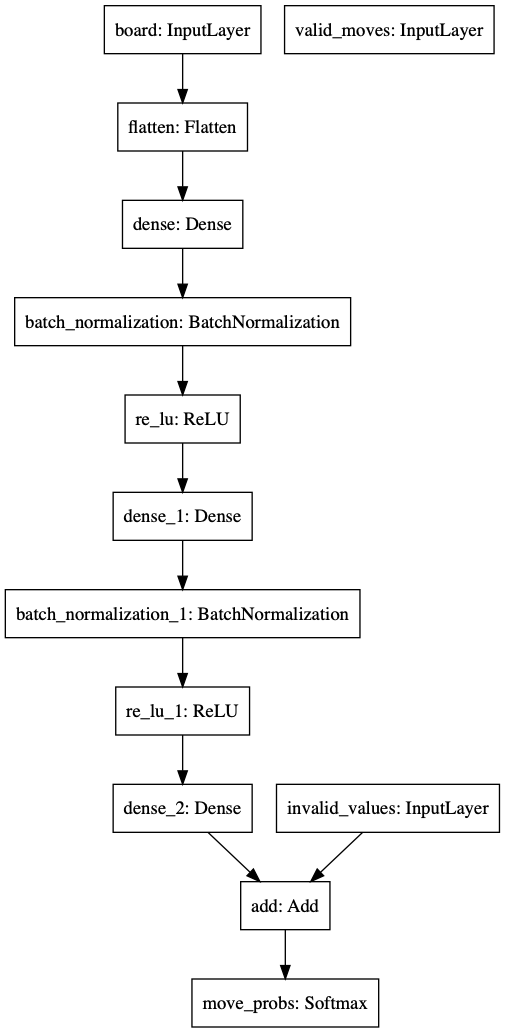

In [13]:
tf.keras.utils.plot_model(actor)

In [14]:
actor.summary()

Model: "actor"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
board (InputLayer)              [(None, 7, 7, 4)]    0                                            
__________________________________________________________________________________________________
flatten (Flatten)               (None, 196)          0           board[0][0]                      
__________________________________________________________________________________________________
dense (Dense)                   (None, 256)          50432       flatten[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256)          1024        dense[0][0]                      
______________________________________________________________________________________________

In [15]:
critic = rl_utils.make_actor_critic('q_net', BOARD_SIZE, critic_activation=None)

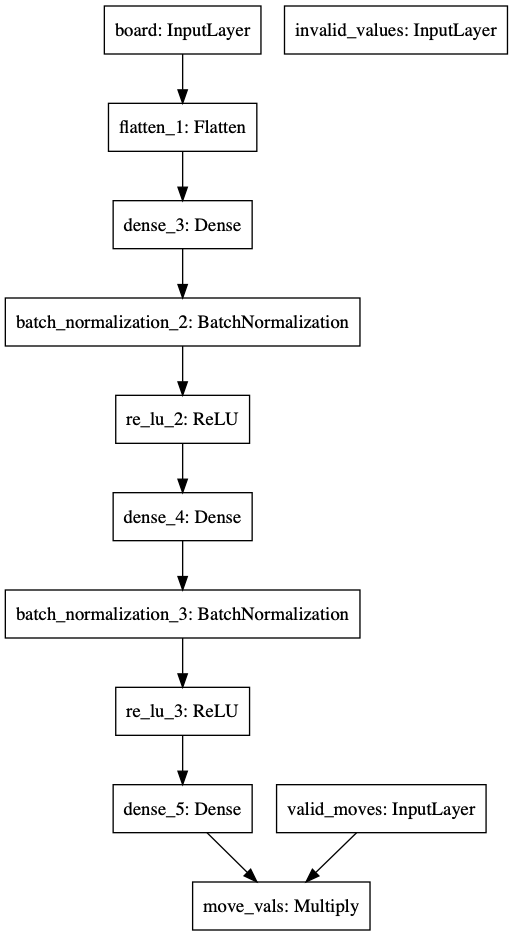

In [16]:
tf.keras.utils.plot_model(critic)

In [17]:
critic.summary()

Model: "q_net"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
board (InputLayer)              [(None, 7, 7, 4)]    0                                            
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 196)          0           board[0][0]                      
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 256)          50432       flatten_1[0][0]                  
__________________________________________________________________________________________________
batch_normalization_2 (BatchNor (None, 256)          1024        dense_3[0][0]                    
______________________________________________________________________________________________

In [18]:
opponent = tf.keras.models.clone_model(actor)

In [19]:
if LOAD_SAVED_MODELS:
    actor.load_weights(ACTOR_PATH)
    critic.load_weights(CRITIC_PATH)
    if LEVEL_PATHS[-1] is not None:
        opponent.load_weights(LEVEL_PATHS[-1])
    logging.info("Loaded models")

I0904 15:37:33.885946 4613756352 <ipython-input-19-67b98c723644>:6] Loaded models


### Initialization of models 

In [20]:
mem = []
state = go_env.reset()
first_action = (2,5)
first_action_1d = go_utils.action_2d_to_1d(first_action, BOARD_SIZE)
second_action = (5,2)
first_state, reward, done, info = go_env.step(first_action)
second_state, reward, done, info = go_env.step(second_action)
rl_utils.add_to_replay_mem(mem, state, first_action_1d, second_state, reward, done, 0)

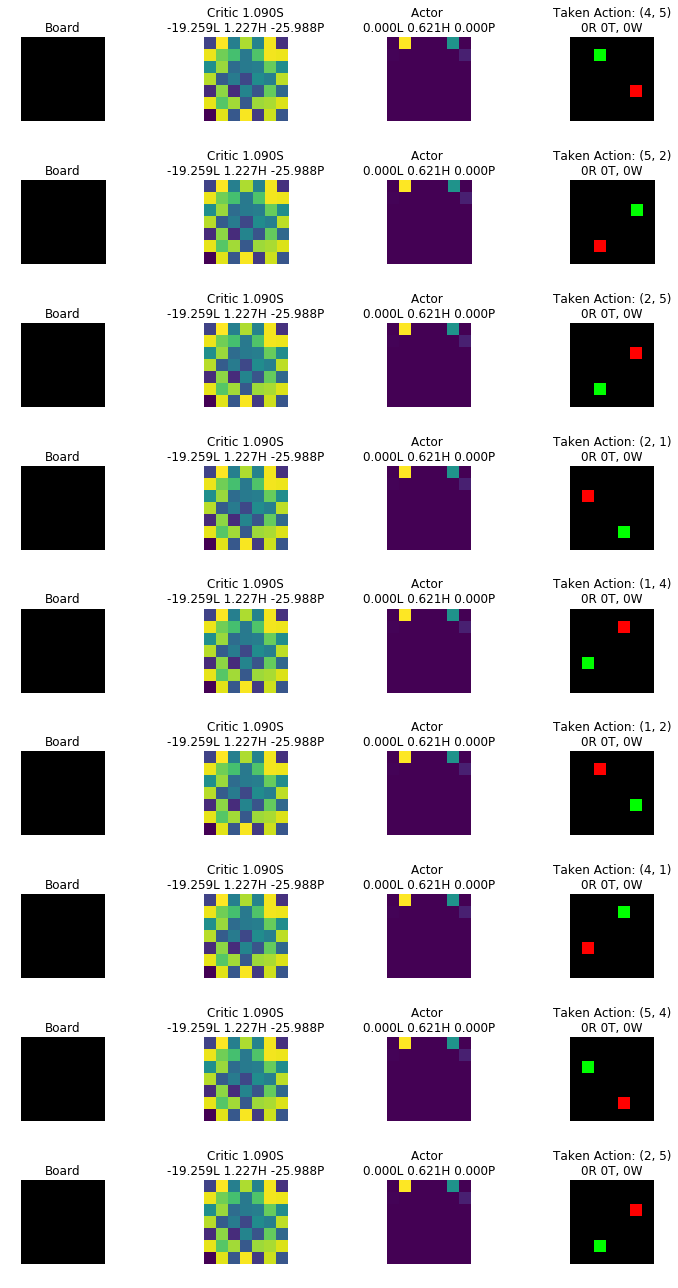

In [21]:
plt.show(rl_utils.sample_heatmaps(actor, critic, mem, num_samples=8))

# Training Setup

### Metrics and Tensorboard

In [22]:
!rm -rf ./logs/

Metrics

In [23]:
metrics = {}
for metric_key in ['val_loss', 'exploit_loss', 'explore_loss', 'win_rate', 'num_steps', 'explore_weight']:
    metrics[metric_key] = tf.keras.metrics.Mean('{}'.format(metric_key), dtype=tf.float32)
metrics['pred_win_acc'] = tf.keras.metrics.Accuracy()

Tensorboard

In [24]:
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = 'logs/actor_critic/{}/main'.format(current_time)
summary_writer = tf.summary.create_file_writer(log_dir)    

### Helper Functions

In [25]:
binary_cross_entropy = tf.keras.losses.BinaryCrossentropy()

In [26]:
EXPLORE_WEIGHT = 16
EXPLORE_DECAY = 0.9
MIN_EXPLORE = 0

In [27]:
actor_opt = tf.keras.optimizers.Adam(ACTOR_LEARNING_RATE, ACTOR_BETA_1)
def update_actor(batched_mem, iteration, metrics):
    """
    Optimizes the actor over the whole replay memory
    """ 
    explore_weight = max(EXPLORE_WEIGHT * (EXPLORE_DECAY**iteration), MIN_EXPLORE)
    for states, actions, next_states, rewards, terminals, wins in tqdm_notebook(batched_mem, desc='Updating actor', 
                                                                                leave=False):
        batch_size = states.shape[0]
        
        # Actor
        state_val_distrs = rl_utils.forward_pass(states, critic, training=False)
        
        valid_moves = go_utils.get_valid_moves(states)
        with tf.GradientTape() as tape:    
            move_prob_distrs = rl_utils.forward_pass(states, actor, training=True)
            assert move_prob_distrs.shape == state_val_distrs.shape
            pred_rewards = tf.reduce_sum(state_val_distrs * move_prob_distrs, axis=1)
            win_loss = tf.reduce_mean(-pred_rewards)
            explore_loss = binary_cross_entropy(valid_moves, move_prob_distrs)
            move_loss = win_loss + explore_weight * explore_loss
        
        metrics['exploit_loss'].update_state(win_loss)
        metrics['explore_loss'].update_state(explore_loss)
        metrics['explore_weight'].update_state(explore_weight)
        
        # compute and apply gradients
        gradients = tape.gradient(move_loss, actor.trainable_variables)
        actor_opt.apply_gradients(zip(gradients, actor.trainable_variables))

In [28]:
critic_opt = tf.keras.optimizers.Adam(CRITIC_LEARNING_RATE, CRITIC_BETA_1)
def update_critic(batched_mem, iteration, metrics):
    """
    Optimizes the critic over the whole replay memory
    """    
    for states, actions, next_states, rewards, terminals, wins in tqdm_notebook(batched_mem, desc='Updating critic', 
                                                                                leave=False):
        batch_size = states.shape[0]
        
        # Critic
        next_move_val_distrs = rl_utils.forward_pass(next_states, critic, training=True)
        next_move_probs = rl_utils.forward_pass(next_states, actor, training=True)
        next_state_vals = tf.math.reduce_sum(next_move_probs * next_move_val_distrs, axis=1)
        target = rewards + CRITIC_GAMMA * next_state_vals
        assert next_state_vals.shape == rewards.shape
        with tf.GradientTape() as tape:
            move_val_distrs = rl_utils.forward_pass(states, critic, training=True)
            move_vals = rl_utils.get_values_for_actions(move_val_distrs, actions)
            assert rewards.shape == move_vals.shape
            val_loss = tf.math.reduce_mean((target - move_vals)**2)
        
        metrics['val_loss'].update_state(val_loss)
#         metrics['pred_win_acc'].update_state(rewards, move_vals > 0.5)
        
        # compute and apply gradients
        gradients = tape.gradient(val_loss, critic.trainable_variables)
        critic_opt.apply_gradients(zip(gradients, critic.trainable_variables))

# Train

In [29]:
replay_mem = []
recent_ratings = collections.deque(maxlen=8)
min_rating_update = 0.1

In [30]:
for iteration in tqdm_notebook(range(ITERATIONS), desc='Iteration'):
    # Update other models if appropriate
    if SAVE_EVERY_ITERATION:
        logging.debug("Saving weights...")
        actor.save_weights(ACTOR_PATH)
        critic.save_weights(CRITIC_PATH)

    # Train
    logging.debug("Playing games")
    episode_pbar = tqdm_notebook(range(EPISODES_PER_ITERATION), desc='Episode {}'.format(iteration), leave=False)
    for episode in episode_pbar:
        # Alternate between black and white going first
        black_won, num_steps = rl_utils.play_a_game(replay_mem, go_env, black_policy=actor, white_policy=opponent, 
                                                    black_first=episode%2==0, max_steps=MAX_STEPS)
                                     
        metrics['win_rate'].update_state(black_won)
        metrics['num_steps'].update_state(num_steps)

    recent_ratings.append(metrics['win_rate'].result().numpy())
    
    # Opponent update
    # Triggered when last few win ratings are all at least a certain threshold
    if len(recent_ratings) == recent_ratings.maxlen and reduce(lambda result, 
                                                               rating: result and rating >= min_rating_update, 
                                                               recent_ratings, True):
        actor.save_weights(ACTOR_PATH)
        critic.save_weights(CRITIC_PATH)
        opponent.load_weights(ACTOR_PATH)
        logging.info("Updated opponent")

    # Update the models (also shuffles memory)
    logging.debug("Updating model...")
    random.shuffle(replay_mem)
    np_data = rl_utils.replay_mem_to_numpy(replay_mem)
    batched_np_data = [np.array_split(datum, len(replay_mem) // BATCH_SIZE) for datum in np_data]
    batched_mem = list(zip(*batched_np_data))
    update_critic(batched_mem, iteration, metrics)
    update_actor(batched_mem, iteration, metrics)  

    # Log results and resets the metrics
    logging.debug("Logging metrics to tensorboard...")
    rl_utils.log_to_tensorboard(summary_writer, metrics, iteration, replay_mem, actor, critic)

    # Reset memory
    replay_mem.clear()

W0904 15:38:01.345160 4613756352 deprecation.py:323] From /usr/local/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1205: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


KeyboardInterrupt: 

# Evaluate

Evaluate against different levels of opponents

In [ ]:
rl_utils.evaluate(go_env, actor, opponent, LEVEL_PATHS, MAX_STEPS)

Play against our AI

In [ ]:
go_env = gym.make('gym_go:go-v0', size=7)
rl_utils.play_against(actor, go_env)